## Chapter 16.1 Sentiment Analysis and the Dataset

In [1]:
import os
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['aclImdb'] = (d2l.DATA_URL + 'aclImdb_v1.tar.gz',
                          '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [4]:
def read_imdb(data_dir, is_train):
    """Read the IMDB review dataset text sequences and labels."""
    
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test', label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels
    
train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))

for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[:60])

# trainings: 25000
label: 1 review: I saw this movie as a teenager and immediately identified wi
label: 1 review: ...On stage, TV or in a book, 'The Woman in Black' is an out
label: 1 review: Does anyone know what kind of pickup John T drove? I looks l


In [5]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

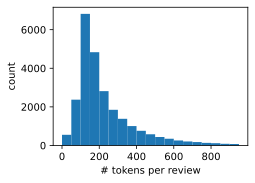

In [6]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

In [7]:
num_steps = 500 # of sequence length
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


In [8]:
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


In [9]:
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])), batch_size, is_train=False)
    
    return train_iter, test_iter, vocab

## Chapter 16.2 Sentiment Analysis: Using Recurrent Neural Networks

In [10]:
import torch
from torch import nn
from d2l import torch as d2l

In [11]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [14]:
class BiRNN(nn.Module):
    
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)
        
    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        
        return outs
    

In [15]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
                
net.apply(init_weights)

BiRNN(
  (embedding): Embedding(49346, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

In [16]:
# Loading Pretrained Word Vectors

glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [17]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [18]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.277, train acc 0.886, test acc 0.857
1416.0 examples/sec on [device(type='cuda', index=0)]


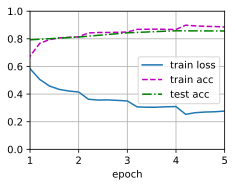

In [19]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [20]:
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [21]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [22]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

* Pretrained word vectors can represent individual tokens in a text sequence.

* Bidirectional RNNs can represent a text sequence, such as via the concatenation of its hidden states at the initial and final time steps. This single text representation can be transformed into categories using a fully connected layer.

## Chapter 16.3 Sentiment Analysis: Using Convolutional Neural

In [23]:
import torch
from torch import nn
from d2l import torch as d2l

In [24]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [26]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i+w] * K).sum()
    return Y

In [27]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

In [28]:
def corr1d_multi_in(X, K):
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
                 [1, 2, 3, 4, 5, 6, 7],
                 [2, 3, 4, 5, 6, 7, 8]])

K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

In [29]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels, **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))
            
    def forward(self, inputs):
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        
        embeddings = embeddings.permute(0, 2, 1)
        
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        
        outputs = self.decoder(self.dropout(encoding))
        
        return outputs

In [30]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)
        
net.apply(init_weights)

TextCNN(
  (embedding): Embedding(49346, 100)
  (constant_embedding): Embedding(49346, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=2, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
)

In [31]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

loss 0.065, train acc 0.979, test acc 0.872
2944.9 examples/sec on [device(type='cuda', index=0)]


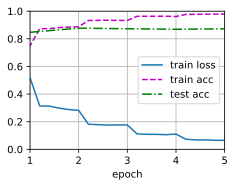

In [32]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [33]:
d2l.predict_sentiment(net, vocab, 'this movie is so greate')

'positive'

In [34]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

* One-dimensional CNNs can process local features such as n-grams in text.

* Multi-input-channel one-dimensional cross-correlations are equivalent to single-input-channel two-dimensional cross-correlations.

* The max-over-time pooling allows different numbers of time steps at different channels.

* The textCNN model transforms individual token representations into downstream application outputs using one-dimensional convolutional layers and max-over-time pooling layers.

## Chapter 16.4 Natural Language Inference and the Dataset

In [35]:
import os
import re
import torch
from torch import nn
from d2l import torch as d2l

In [36]:
d2l.DATA_HUB['SNLI'] = ('https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = d2l.download_extract('SNLI')

In [44]:
def read_snli(data_dir, is_train):
    """Read the SNLI dataset into premises, hypotheses, and labels."""
    
    def extract_text(s):
        # Remove information that will not be used by us
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    
    label_set = {'entailment': 0, 'contradiction':1, 'neutral':2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
                            if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [45]:
train_data = read_snli(data_dir, is_train=True)

for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('premise:', x0)
    print('hypothesis:', x1)
    print('label:', y)

premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is training his horse for a competition .
label: 2
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is at a diner , ordering an omelette .
label: 1
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is outdoors , on a horse .
label: 0


In [46]:
test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    print([[row for row in data[2]].count(i) for i in range(3)])
    

[183416, 183187, 182764]
[3368, 3237, 3219]


In [47]:
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset."""
    
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                  min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')
        
    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                            for line in lines])
    
    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]
    
    def __len__(self):
        return len(self.premises)

In [48]:
def load_data_snli(batch_size, num_steps=50):
    """Download the SNLI dataset and return data iterators and vocabulary."""
    
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('SNLI')
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, 
                                             shuffle=True,
                                            num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size, 
                                           shuffle=False,
                                           num_workers=num_workers)
    
    return train_iter, test_iter, train_set.vocab

In [52]:
train_iter, test_iter, vocab = load_data_snli(128, 50)
len(vocab)

read 549367 examples
read 9824 examples


18678

In [53]:
for X, Y in train_iter:
    print(X[0].shape)
    print(X[1].shape)
    print(Y.shape)
    break

Process Process-9:
Traceback (most recent call last):
Process Process-10:
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process Process-11:
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 225, in _worker_loop
    torch.manual_seed(seed)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/torch/random.py", line 44, in ma

RuntimeError: DataLoader worker (pid(s) 14128) exited unexpectedly

* Natural language inference studies whether a hypothesis can be inferred from a premise, where both are a text sequence.

* In natural language inference, relationships between premises and hypotheses include entailment, contradiction, and neutral.

* Stanford Natural Language Inference (SNLI) Corpus is a popular benchmark dataset of natural language inference.

## Chapter 16.5 Natural Language Inference: Using Attention

In [3]:
!pip install -U torch==2.0.0 torchvision==0.15.1

In [4]:
!pip install -U d2l==1.0.3

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [4]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    
    return nn.Sequential(*net)

In [5]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)
        
    def forward(self, A, B):
        
        f_A = self.f(A)
        f_B = self.f(B)
        
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        
        return beta, alpha

In [6]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)
        
    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

In [7]:
class Aggregate(nn.Module):
    
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)
        
    def forward(self, V_A, V_B):
        
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        
        return Y_hat

In [8]:
class DecomposableAttention(nn.Module):
    
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100, 
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)
        
    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

In [9]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples


In [13]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)

tensor([[ 0.3847,  0.4935,  0.4910,  ...,  0.0263,  0.3905,  0.5222],
        [-0.6610, -0.0730,  0.9238,  ..., -0.2256,  0.8148, -0.4405],
        [ 0.9747,  1.2276,  0.4538,  ...,  0.2209,  1.7439, -0.8991],
        ...,
        [-0.0205, -0.4512,  0.6993,  ...,  0.0381,  0.2786,  0.2889],
        [-0.2484, -0.2568,  0.0255,  ...,  0.2161, -0.3413,  0.6266],
        [-0.1438,  0.8681, -0.7219,  ...,  0.0553, -0.4339,  0.3486]])

In [10]:
# don't run this, will fail the next block.

def split_batch_multi_inputs(X, y, devices):
    """Split multi-input X and y into multiple devices."""
    
    X = list(zip(*[gluon.utils.split_and_load(
        feature, devices, even_split=False) for feature in X]))
    
    return (X, gluon.utils.split_and_load(y, devices, even_split=False))

loss 0.495, train acc 0.805, test acc 0.828
19272.0 examples/sec on [device(type='cuda', index=0)]


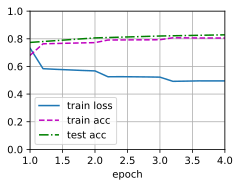

In [14]:
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [15]:
def predict_snli(net, vocab, premise, hypothesis):
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)), 
                             hypothesis.reshape((1, -1))]), dim=1)
    
    return 'entailment' if label ==0 else 'contradiction' if label == 1 else 'neutral'

In [16]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'

## Chapter 16.6 Fine-Tuning BERT for Sequence-Level and Token-Level Applications

* BERT requires minimal architecture changes (extra fully connected layers) for sequence-level and token-level natural language processing applications, such as single text classification (e.g., sentiment analysis and testing linguistic acceptability), text pair classification or regression (e.g., natural language inference and semantic textual similarity), text tagging (e.g., part-of-speech tagging), and question answering.

* During supervised learning of a downstream application, parameters of the extra layers are learned from scratch while all the parameters in the pretrained BERT model are fine-tuned.

## Chapter 16.7 Natural Language Inference: Fine-Tuning BERT

In [28]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

In [29]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [30]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                         num_heads, num_blks, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    
    bert = d2l.BERTModel(
        len(vocab), num_hiddens, ffn_num_hiddens=ffn_num_hiddens, num_heads=4, 
        num_blks=2, dropout=0.2, max_len=max_len)
    
    bert.load_state_dict(torch.load(os.path.join(data_dir, 'pretrained.params')))
    
    return bert, vocab

In [31]:
devices = d2l.try_all_gpus()

bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_blks=2, dropout=0.1, max_len=512, devices=devices)

In [32]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
             for sentences in dataset[:2]])]
        
        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
        self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')
        
    
    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        
        return (torch.tensor(all_token_ids, dtype=torch.long),
               torch.tensor(all_segments, dtype=torch.long),
               torch.tensor(valid_lens))
    
    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                            * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        
        return token_ids, segments, valid_len
    
    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()
                
    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx], 
               self.valid_lens[idx]), self.labels[idx]
    
    def __len__(self):
        return len(self.all_token_ids)

In [33]:
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()

data_dir = d2l.download_extract('SNLI')

train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)

train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size, num_workers=num_workers)

read 549367 examples
read 9824 examples


In [34]:
class BERTClassifier(nn.Module):
    
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.LazyLinear(3)
        
    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

In [35]:
net = BERTClassifier(bert)

loss 0.521, train acc 0.789, test acc 0.782
2804.5 examples/sec on [device(type='cuda', index=0)]


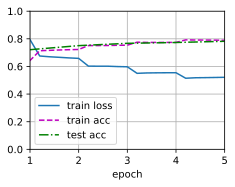

In [36]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
net(next(iter(train_iter))[0])
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

* We can fine-tune the pretrained BERT model for downstream applications, such as natural language inference on the SNLI dataset.

* During fine-tuning, the BERT model becomes part of the model for the downstream application. Parameters that are only related to pretraining loss will not be updated during fine-tuning.